In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords

#sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["user", "time", "text", "label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 12
BATCH_SIZE = 1024

# SENTIMENT
NO_EMOTION = "NO_EMOTION"
EMOTION = "EMOTION"

### Read Dataset

In [4]:
df = pd.read_csv('D:/NLP/Dataset/1_tj-stage1.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
print("Dataset size:", len(df))

Dataset size: 37793


In [6]:
df.head(5)

,user,time,text,label
0,khoryfm,9/30/2017 6:47,salam mau tanya halte slip mau gramedia matram...,0
1,dheerman,9/30/2017 6:17,rute ciledug bundar hi operasi tidak hari ini,0
2,inelism16,9/30/2017 6:07,selamat pagi mau tnya mau bni gatot subroto tu...,0
3,bey8_,9/30/2017 6:05,ciledug-tosari sabtu ga,0
4,dhanubhaskaraaa,9/30/2017 3:44,maaf mau tanya busway arah rambutan harmoni su...,0


In [7]:
decode_map = {0: "NO_EMOTION", 1: "EMOTION"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.label = df.label.apply(lambda x: decode_sentiment(x))

CPU times: total: 15.6 ms
Wall time: 17 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

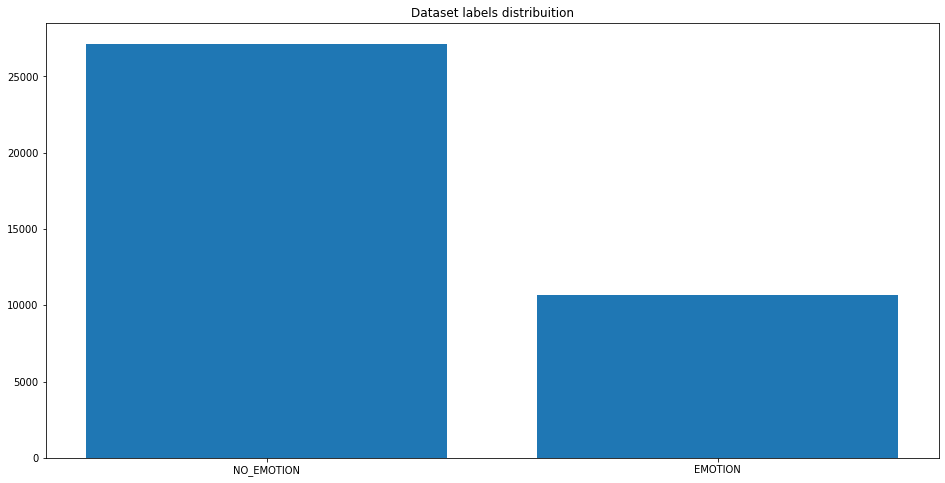

In [9]:
label_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(label_cnt.keys(), label_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("indonesian")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 3.75 s
Wall time: 3.86 s


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=0)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 34013
TEST size: 3780


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 188 ms
Wall time: 208 ms


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-07-10 19:34:08,409 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-07-10T19:34:08.409903', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [16]:
w2v_model.build_vocab(documents)

2022-07-10 19:34:08,436 : INFO : collecting all words and their counts
2022-07-10 19:34:08,438 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-10 19:34:08,466 : INFO : PROGRESS: at sentence #10000, processed 78396 words, keeping 9418 word types
2022-07-10 19:34:08,494 : INFO : PROGRESS: at sentence #20000, processed 156428 words, keeping 13971 word types
2022-07-10 19:34:08,524 : INFO : PROGRESS: at sentence #30000, processed 233824 words, keeping 17673 word types
2022-07-10 19:34:08,537 : INFO : collected 18983 word types from a corpus of 264815 raw words and 34013 sentences
2022-07-10 19:34:08,539 : INFO : Creating a fresh vocabulary
2022-07-10 19:34:08,563 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 2396 unique words (12.62% of original 18983, drops 16587)', 'datetime': '2022-07-10T19:34:08.563912', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platfor

In [17]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2396


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-07-10 19:34:08,693 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 2396 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-07-10T19:34:08.693932', 'gensim': '4.2.0', 'python': '3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
2022-07-10 19:34:09,006 : INFO : EPOCH 0: training on 264815 raw words (182901 effective words) took 0.3s, 673915 effective words/s
2022-07-10 19:34:09,307 : INFO : EPOCH 1: training on 264815 raw words (183176 effective words) took 0.3s, 665153 effective words/s
2022-07-10 19:34:09,604 : INFO : EPOCH 2: training on 264815 raw words (182888 effective words) took 0.2s, 736885 effective words/s
2022-07-10 19:34:09,912 : INFO : EPOCH 3: training on 264815 raw words (183211 effective words) took 0.3s, 655873 effective words/s
2022-07-10 19:34:10,212 : INFO : EPOCH 4: training on

CPU times: total: 26.3 s
Wall time: 9.4 s


(5859292, 8474080)

In [19]:
w2v_model.wv.most_similar("bagus")

[('media', 0.6023578643798828),
 ('keren', 0.5872167348861694),
 ('zaman', 0.5737758278846741),
 ('awak', 0.572938859462738),
 ('jelek', 0.5626378655433655),
 ('jiwa', 0.5500825643539429),
 ('asa', 0.5496142506599426),
 ('direksi', 0.5494240522384644),
 ('sebentar', 0.5481710433959961),
 ('lilin', 0.5480616688728333)]

### Tokenize Text

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 18984
CPU times: total: 609 ms
Wall time: 615 ms


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 625 ms
Wall time: 632 ms


### Label Encoder 

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (34013, 1)
y_test (3780, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (34013, 300)
y_train (34013, 1)

x_test (3780, 300)
y_test (3780, 1)


In [24]:
y_train[:10]

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]])

### Embedding layer

In [25]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(18984, 300)


In [26]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          5695200   
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 75, 32)            8

### Compile model

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [29]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Train

In [30]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/12
30/30 [==============================] - 141s 5s/step - loss: 0.5034 - accuracy: 0.7418 - val_loss: 0.4187 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 2/12
30/30 [==============================] - 137s 5s/step - loss: 0.4046 - accuracy: 0.8074 - val_loss: 0.3712 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 3/12
30/30 [==============================] - 137s 5s/step - loss: 0.3605 - accuracy: 0.8311 - val_loss: 0.3665 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 4/12
30/30 [==============================] - 138s 5s/step - loss: 0.3302 - accuracy: 0.8484 - val_loss: 0.3515 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 5/12
30/30 [==============================] - 137s 5s/step - loss: 0.2997 - accuracy: 0.8651 - val_loss: 0.3614 - val_accuracy: 0.8398 - lr: 0.0010
Epoch 6/12
30/30 [==============================] - 136s 5s/step - loss: 0.2727 - accuracy: 0.8800 - val_loss: 0.4019 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 7/12
30/30 [==============================] - 136s 5s/step - loss: 0.2

### Evaluate

In [31]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 7s 2s/step - loss: 0.6265 - accuracy: 0.8280

ACCURACY: 0.8280423283576965
LOSS: 0.6264680624008179
CPU times: total: 24.7 s
Wall time: 6.74 s


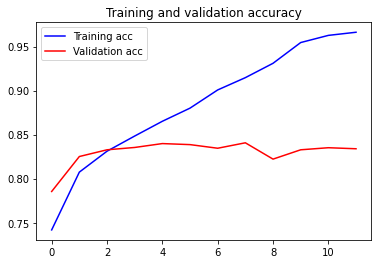

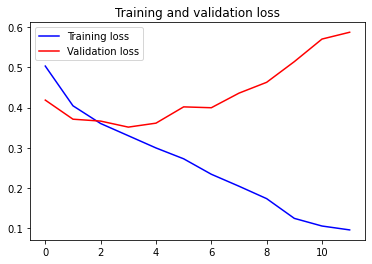

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Confusion Matrix

In [33]:
import seaborn as sns

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

119/119 [==============================] - 8s 63ms/step


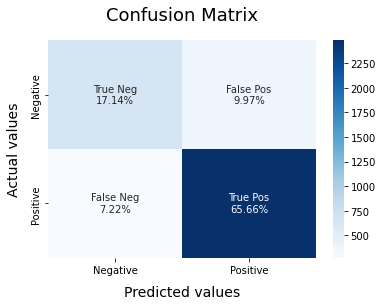

In [34]:
# Predicting on the Test dataset.
y_pred = model.predict(x_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

### Classification Report

In [35]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7036    0.6322    0.6660      1025
           1     0.8681    0.9009    0.8842      2755

    accuracy                         0.8280      3780
   macro avg     0.7859    0.7666    0.7751      3780
weighted avg     0.8235    0.8280    0.8250      3780



### Accuracy Score

In [36]:
accuracy_score(y_test, y_pred)

0.828042328042328

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)